In [1]:
!git clone https://github.com/andriygav/MixtureLib.git
!python3 -m pip install MixtureLib/src/.

Cloning into 'MixtureLib'...
remote: Enumerating objects: 177, done.
remote: Counting objects: 100% (177/177), done.
remote: Compressing objects: 100% (144/144), done.
remote: Total 177 (delta 77), reused 91 (delta 22), pack-reused 0
Receiving objects: 100% (177/177), 1.85 MiB | 17.23 MiB/s, done.
Resolving deltas: 100% (77/77), done.
Processing ./MixtureLib/src
  Created wheel for MixtureLib: filename=MixtureLib-0.0.1-cp36-none-any.whl size=6369 sha256=328cdc654c7bc309eecf18d68bed9b9ab719b65e3dc4905bc2485535549ddc9f
  Stored in directory: /tmp/pip-ephem-wheel-cache-l4q8hbsw/wheels/8f/0e/0e/7b633cbf34c93d96d5b40677655ae6cda78087b2231b3cb1dc
Successfully built MixtureLib


In [0]:
from MixtureLib.Mixture import MixtureEM, MixtureEmSample
from MixtureLib.LocalModels import EachModelLinear
from MixtureLib.HyperModels import HyperExpertNN, HyperModelDirichlet


import matplotlib.pyplot as plt
from matplotlib import gridspec

from tqdm import tqdm_notebook as tqdm
import numpy as np
import torch


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [0]:
#np.random.seed(0)
def f_1(x):
    return 20*x[0] + np.random.randn()

def f_2(x):
    return 30*x[0] + np.random.randn()
N = 200
n = 2

#w1 = np.random.randn(n)
#X1 = np.random.multivariate_normal(-3*np.ones(n), np.eye(n), size = N)

#w2 = np.random.randn(n)
#X2 = np.random.multivariate_normal(3*np.ones(n), np.eye(n), size = N)

#X = np.vstack([X1, X2])

#Y = np.vstack([X1@w1, X2@w2])
nn = 200 

x1 = np.random.randn(nn, 1)
x2 = np.random.randn(nn, 1)
y1 = np.array([f_1(x) for x in x1])
y2 = np.array([f_2(x) for x in x2])

#X1 = np.hstack([x1, np.random.randn(nn,1)]) #две выборки, когда признаки заполняются случайно
#X2 = np.hstack([np.random.randn(nn,1), x2])
X1 = np.hstack([x1, np.zeros([nn,1])])#две выборки, когда признаки заполняются нулями
X2 = np.hstack([np.zeros([nn,1]), x2])
                
X = np.vstack([X1, X2])
Y = np.hstack([y1, y2])

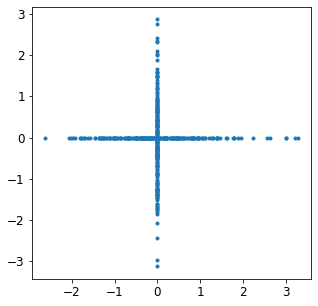

In [87]:
FONT_SIZE = 12

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['axes.titlesize']=FONT_SIZE
plt.rcParams['axes.labelsize']=FONT_SIZE
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['font.size'] = FONT_SIZE
##############################################

_ = plt.plot(X[:, 0], X[:, 1], '.')

In [88]:
X_tr = torch.FloatTensor(X)
Y_tr = torch.FloatTensor(Y).view([-1,1])

X_tr.shape, Y_tr.shape

(torch.Size([400, 2]), torch.Size([400, 1]))

In [0]:
K = 2
epoch = 40

In [90]:
List_of_ind = []
List_of_W = []

LoM = []
for k in range(K):
    LoM.append(EachModelLinear(input_dim = n, device = device))

HypPar = {'beta': 1.}

HpMd = HyperExpertNN(input_dim = n, hidden_dim = 5, output_dim = K, device = device, epochs=1000)

model = MixtureEmSample(input_dim = n, K = K, HyperParameters = HypPar, HyperModel = HpMd, ListOfModels = LoM, device = device)

for _ in tqdm(range(epoch)):
    model.fit(X_tr, Y_tr, 1, progress = None)
    List_of_ind.append(np.argmax(model.predict(X_tr)[1], axis = 1))
    List_of_W.append(np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels]))
    
    
List_of_ind = np.array(List_of_ind)
List_of_W = np.array(List_of_W)

In [93]:
weights = np.array([m.W.data.numpy().reshape(-1) for m in model.ListOfModels])
weights

array([[20.218487, 29.969416],
       [19.777605, 30.277927]], dtype=float32)

In [94]:
W_true = np.array([w1, w2])
W_true

array([[1.76405235, 0.40015721],
       [1.0996596 , 0.65526373]])

In [95]:
((Y_tr-model.predict(X_tr)[0])**2).mean()

tensor(0.8999)

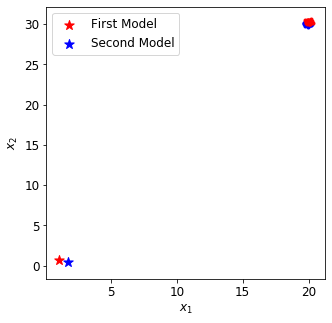

In [96]:
color = ['blue', 'red', 'black', 'black', 'black']
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['axes.titlesize']=FONT_SIZE
plt.rcParams['axes.labelsize']=FONT_SIZE
plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams['font.size'] = FONT_SIZE
##############################################



for i in range(List_of_W.shape[1]):
    plt.plot(List_of_W[:, i, 0], List_of_W[:, i, 1], '.', color=color[i])

plt.rcParams['lines.markersize'] = 10
plt.scatter(W_true[1, 0], W_true[1, 1], marker='*', c=color[1], label = 'First Model')
plt.scatter(W_true[0, 0], W_true[0, 1], marker='*', c=color[0], label = 'Second Model')

plt.legend(loc='best')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pylab import *

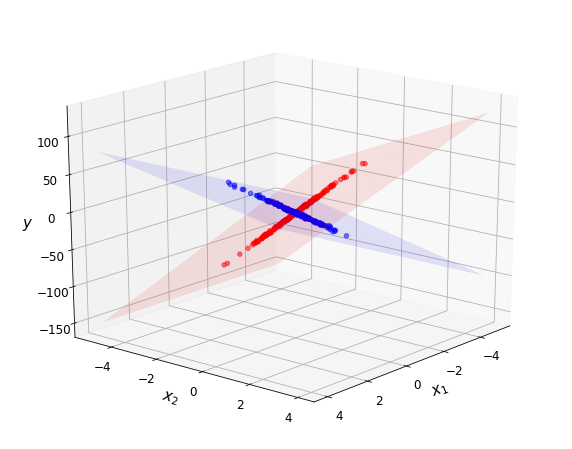

In [98]:
fig = plt.figure(figsize=(10, 8))

b = [0 for i in range(n)]

ax = fig.add_subplot(111, projection='3d')

xx, yy = np.meshgrid(range(-5, 5), range(-5, 5))

z1 = 0.0001 * np.array(xx) + weights[0,1] * np.array(yy)
z2 = weights[1,0] * np.array(xx) + 0.0001*np.array(yy)
ax.scatter(X[0:200, 0],X[0:200, 1], y1, alpha=0.5, color='blue')
ax.scatter(X[200:400, 0],X[200:400, 1], y2, alpha=0.5, color='red')
#ax.scatter(y, x, z2, color='red')
#ax.scatter(y11, x, z2, color='red')
#ax.scatter(y22, x, z2, color='red')
ax.plot_surface(xx, yy, z1, alpha = 0.1, color = 'red')
ax.plot_surface(xx, yy, z2, alpha = 0.1, color = 'blue')
ax.view_init(20,40)
ax.set_xlabel('$x_1$', fontsize=15, fontweight="bold")
ax.set_ylabel('$x_2$', fontsize=15, fontweight="bold")
ax.set_zlabel('$y$', fontsize=15, fontweight="bold")
#ax.set_title('', fontsize=15, fontweight="bold")
savefig('experiment2-zeros.pdf')

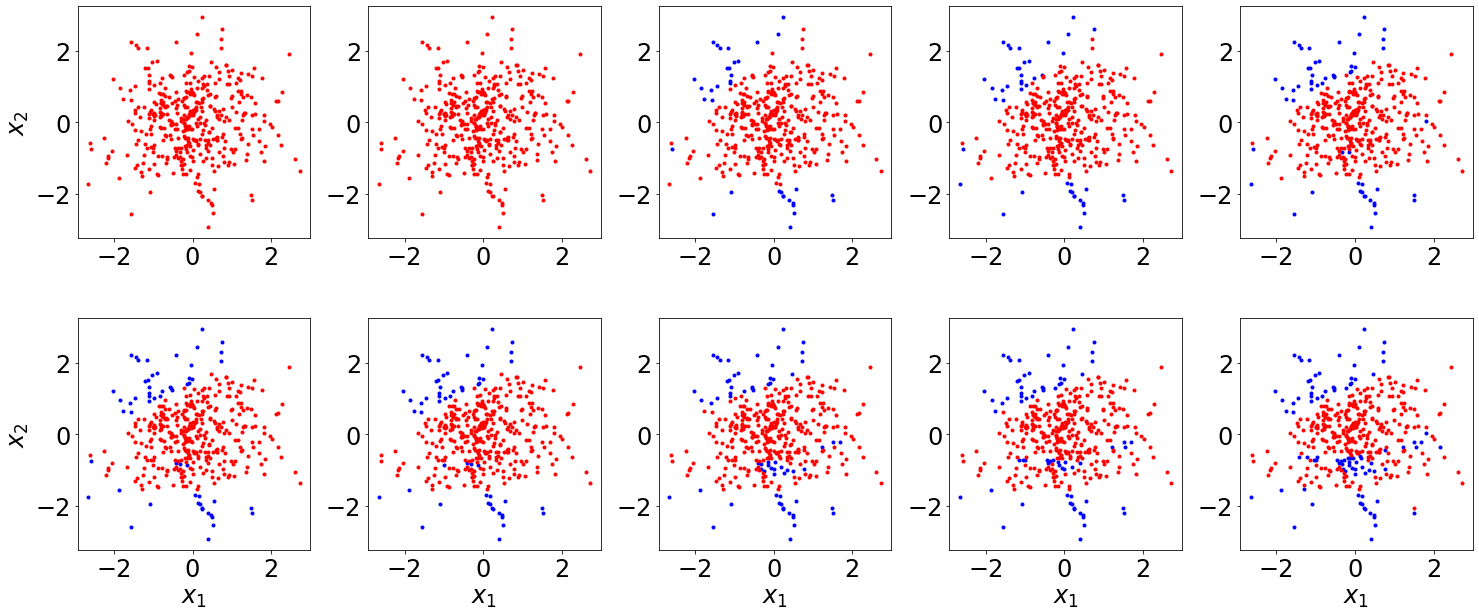

In [84]:
FONT_SIZE = 24

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 6
plt.rcParams['xtick.labelsize'] = FONT_SIZE
plt.rcParams['ytick.labelsize'] = FONT_SIZE
plt.rcParams['legend.fontsize'] = FONT_SIZE
plt.rcParams['axes.titlesize']=FONT_SIZE
plt.rcParams['axes.labelsize']=FONT_SIZE
plt.rcParams['figure.figsize'] = (25.0, 10.0)
plt.rcParams['font.size'] = FONT_SIZE
##############################################

fig = plt.figure();

gs = gridspec.GridSpec(2, 5)

ax = []
for i, g in enumerate(gs):
    ax.append(fig.add_subplot(g))
    if (len(ax) - 1) % 5 == 0:
        ax[-1].set_ylabel('$x_2$')
    if len(ax) > 5:
        ax[-1].set_xlabel('$x_1$')
    

for e, (idx, _) in enumerate(zip(List_of_ind[:10], List_of_W[:10])):
    for i in np.unique(idx):
        indexes = np.where(idx == i)
        _ = ax[e].plot(X[indexes, 0], X[indexes, 1], '.', color=color[i])

plt.subplots_adjust(wspace=0.25, hspace=0.35)
plt.show()